In [1]:
library(survival)
library(data.table)
library(stringr)
library(survminer)
library(ggplot2)
library(ggsurvfit)
library(org.Hs.eg.db)
library(stringi)
library(clusterProfiler)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVigne

# Survival analysis

In [2]:
expr = fread('/home/renpf/pan/jie/data/TCGA_UCSD/TCGA/COAD/RNA',header = T, sep = '\t')
expr = as.data.frame(expr)
rownames(expr) = expr[,1]
expr = expr[,-1]

table(unlist(lapply(colnames(expr), function(x){
    unlist(str_split(x,'-'))[4]
})))
expr = expr[,str_which(colnames(expr),'-01')]

survive = read.table('/home/renpf/pan/jie/data/TCGA_UCSD/TCGA/COAD/Survival',header = TRUE,sep = '\t')
survive = survive[str_which(survive$sample,'-01'),]
colnames(expr) = gsub('-01','',colnames(expr))

patients = intersect(colnames(expr),survive$X_PATIENT)
expr = expr[patients]
rownames(survive) = survive$X_PATIENT
survive = survive[patients,]
dim(survive)
dim(expr)


 01  02  06  11 
286   1   1  41 

[1] 283  11

[1] 20530   283

In [12]:
survive$CD44 = as.vector(t(expr['CD44',rownames(survive)]))
survive$SPP1 = as.vector(t(expr['SPP1',rownames(survive)]))
survive$INF2 = as.vector(t(expr['INF2',rownames(survive)]))
survive$C1QC = as.vector(t(expr['C1QC',rownames(survive)]))

sruvive_plot1 = function(gene1){
    #指定基因
    gene2 = 'CD44'
    #初始化signature
    survive_temp = survive
    survive_temp$signature = 'none'
    #为每个sample分配一个标签
    quantiles1 = quantile(survive_temp[,gene1],seq(0,1,0.1))
    quantiles2 = quantile(survive_temp[,gene2],seq(0,1,0.1))
    sit1 = (survive_temp[,gene1] >= median(survive_temp[,gene1])) & (survive_temp[,gene2] >= median(survive_temp[,gene2]))
    sit2 = (survive_temp[,gene1] < median(survive_temp[,gene1])) & (survive_temp[,gene2] < median(survive_temp[,gene2]))
    sit3 = (survive_temp[,gene1] >= median(survive_temp[,gene1])) & (survive_temp[,gene2] < median(survive_temp[,gene2]))
    sit4 = (survive_temp[,gene1] < median(survive_temp[,gene1])) & (survive_temp[,gene2] >= median(survive_temp[,gene2]))
    
    survive_temp$signature[sit1] = paste0('Both high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0('Both low (n=',sum(sit2),')')
    survive_temp$signature[sit3] = paste0(gene1,' high (n=',sum(sit3),')')
    survive_temp$signature[sit4] = paste0(gene2,' high (n=',sum(sit4),')')
    survive_temp = survive_temp[!survive_temp$signature == 'none',]
    
    #指定颜色
    colors = c('#E2B56D','#6792C5','#EE8776','#E38AE0')
    names(colors) = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')'))
    print(names(colors))
    #计算p值
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #plot
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1800, y = 0.5, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.75,0.8),
              title = element_text(size = 11,family="Helvetica",colour = "black"),
              axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
              axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
              axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
              axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
              legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
              axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
              axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
              axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
              axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
            ) + 
        add_censor_mark() +
        labs(x = 'Time (days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')')),
                            labels = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')')))
}

[1] "Both high (n=77)" "Both low (n=76)"  "SPP1 high (n=65)" "CD44 high (n=65)"


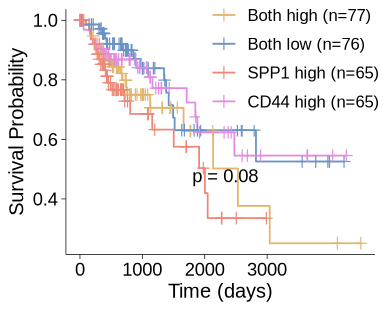

In [14]:
options(repr.plot.width = 3.2, repr.plot.height = 2.6)
sruvive_plot1('SPP1')

ggsave(filename = "SPP1_CD44_survival_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 6.4, height = 5.2, dpi = 300)

[1] "Both high (n=74)" "Both low (n=73)"  "C1QC high (n=68)" "CD44 high (n=68)"


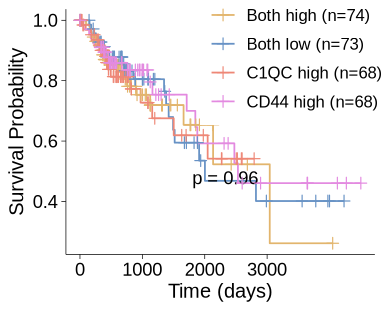

In [13]:
options(repr.plot.width = 3.2, repr.plot.height = 2.6)
sruvive_plot1('C1QC')

ggsave(filename = "C1QC_CD44_survival_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 6.4, height = 5.2, dpi = 300)

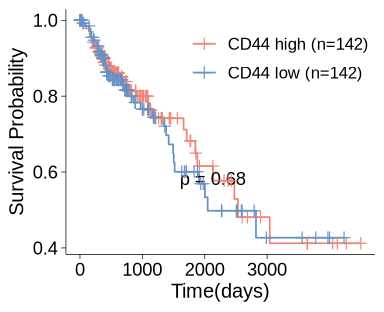

In [18]:
survive_plot2 = function(){
    gene = 'CD44'
    sit1 = (survive_temp[,gene] >= median(survive_temp[,gene]))
    sit2 = (survive_temp[,gene] <= median(survive_temp[,gene]))
    survive_temp$signature[sit1] = paste0(gene,' high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0(gene,' low (n=',sum(sit2),')')
    survive_temp = survive_temp[survive_temp$signature!='none',]
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #指定颜色
    colors = c("#EE8776", "#6792C5")
    names(colors) = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')'))
    #plot
    options(repr.plot.width = 3.2, repr.plot.height = 2.6)
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1600, y = 0.6, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.7,0.8),
                  title = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
                  legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
                  axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
                ) + 
        add_censor_mark() +
        labs(x = 'Time(days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')),
                            labels = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')))
}

survive_temp = survive
survive_plot2()

ggsave(filename = "CD44_survival_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 6.4, height = 5.2, dpi = 300)

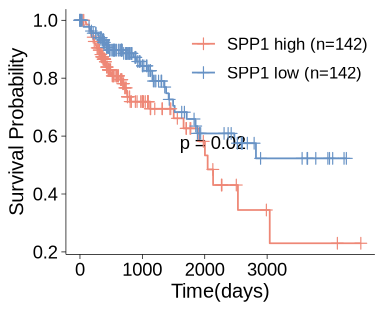

In [10]:
survive_plot2 = function(){
    gene = 'SPP1'
    sit1 = (survive_temp[,gene] >= median(survive_temp[,gene]))
    sit2 = (survive_temp[,gene] <= median(survive_temp[,gene]))
    survive_temp$signature[sit1] = paste0(gene,' high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0(gene,' low (n=',sum(sit2),')')
    survive_temp = survive_temp[survive_temp$signature!='none',]
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #指定颜色
    colors = c("#EE8776", "#6792C5")
    names(colors) = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')'))
    #plot
    options(repr.plot.width = 3.2, repr.plot.height = 2.6)
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1600, y = 0.6, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.7,0.8),
                  title = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
                  legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
                  axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
                ) + 
        add_censor_mark() +
        labs(x = 'Time(days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')),
                            labels = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')))
}

survive_temp = survive
survive_plot2()

ggsave(filename = "SPP1_survival_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 6.4, height = 5.2, dpi = 300)

# Expression analysis

In [3]:
ros_genes <- c('CSDE1', 'DNAJC8', 'DNAJB9', 'PRDX5', 'GCLM', 'DNAJA3', 'CCT7', 'GSTP1', 'FTH1', 'NCF1', 
'CCT8', 'CYBA', 'DNAJB11', 'PRDX2', 'GSR', 'HSPA1A', 'DNAJC5', 'SOD2', 'PRDX3', 'DNAJB6', 'KEAP1')

ros_genes <- c("ABCB11","ABCC1","ABCD1","ABL1","ADAM9","ADCYAP1R1","ADIPOQ","ADPRS","AGAP3","AIF1",
"AIFM1","AIFM2","AKT1","ALAD","ALDH3B1","ALOX5","ALS2","ANGPTL7","ANKZF1","APOA4","APOD","APOE","APP",
"AQP1","AREG","ARL6IP5","ARNT","ATF2","ATF4","ATM","ATOX1","ATP13A2","ATP2A2","ATP7A","AXL","BAK1",
"BANF1","BCL2","BECN1","BMAL1","BMP7","BNIP3","BRF2","BTK","C19orf12","CAMKK2","CAPN2","CASP3","CAT",
"CBX8","CCS","CD2AP","CD36","CD38","CDK1","CHCHD2","CHCHD4","CHRNA4","CHUK","COA8","COL1A1","COL6A1",
"COMT","CRK","CRYAB","CRYGD","CYB5B","CYGB","CYP1B1","DAPK1","DDR2","DGKK","DHFR","DHFRP1","DHRS2",
"DUOX1","DUOX2","ECT2","EDN1","EDNRA","EGFR","EIF2S1","EPAS1","EPX","ERCC1","ERCC2","ERCC3","ERCC6",
"ERCC6L2","ERCC8","ERMP1","ERN1","ERO1A","ETFDH","ETV5","EZH2","FABP1","FADS2","FANCC","FANCD2",
"FBLN5","FER","FGF8","FKBP1B","FOS","FOSL1","FOXO1","FOXO3","FOXO4","FOXP1","FUT8","FXN","FYN","G6PD",
"GCH1","GCLC","GCLM","GGT7","GJB2","GLRX2","GPR37","GPR37L1","GPX1","GPX2","GPX3","GPX4","GPX5",
"GPX6","GPX7","GPX8","GSR","GSS","GSTP1","HAO1","HBA1","HBA2","HBB","HDAC2","HDAC6","HGF","HIF1A",
"HM13","HMOX1","HMOX2","HP","HSF1","HSPA1A","HSPA1B","HSPA8","HTRA2","HYAL1","HYAL2","IDH1","IL18BP",
"IL18RAP","IL1A","IL6","IPCEF1","JAK2","JUN","KAT2B","KCNA5","KDM6B","KEAP1","KLF2","KLF4","KRT1",
"LIAS","LONP1","LPO","LRRK2","MACROH2A1","MAP1LC3A","MAP2K4","MAP3K5","MAPK1","MAPK13","MAPK3","MAPK7",
"MAPK8","MAPK9","MAPKAP1","MAPT","MB","MBL2","MCTP1","MDM2","MEAK7","MET","MGAT3","MGST1","MICB",
"MIR103A1","MIR107","MIR132","MIR133A1","MIR135A1","MIR17","MIR21","MIR34A","MIR92A1","MIRLET7B",
"MMP14","MMP2","MMP3","MMP9","MPO","MPV17","MSRA","MSRB2","MSRB3","MT-CO1","MT-ND1","MT-ND3","MT-ND5",
"MT-ND6","MT3","MTF1","MYB","NAGLU","NAPRT","NCF1","NCOA7","NDUFA12","NDUFA6","NDUFB4","NDUFS2",
"NDUFS8","NEIL1","NET1","NFE2L2","NME8","NOS3","NQO1","NR4A2","NUDT1","NUDT15","NUDT2","OGG1","OSER1",
"OXR1","OXSR1","PARK7","PARP1","PAWR","PCGF2","PCNA","PDCD10","PDGFD","PDGFRA","PDK2","PDLIM1","PENK",
"PEX10","PEX12","PEX13","PEX14","PEX2","PEX5","PINK1","PJVK","PKD2","PLA2R1","PLEKHA1","PLK3","PNKP",
"PNPLA8","PNPT1","PPARGC1A","PPARGC1B","PPIA","PPIF","PPP1R15B","PPP2CB","PRDX1","PRDX2","PRDX3",
"PRDX4","PRDX5","PRDX6","PRKAA1","PRKAA2","PRKCD","PRKD1","PRKN","PRKRA","PRNP","PRR5L","PSEN1",
"PSIP1","PSMB5","PTGS1","PTGS2","PTK2B","PTPRK","PTPRN","PXDN","PXDNL","PXN","PYCR1","PYCR2","PYROXD1",
"RACK1","RAD52","RBM11","RBPMS","RBX1","RCAN1","RELA","RGS14","RHOB","RIPK1","RIPK3","RLIG1","RNF112",
"ROMO1","RPS3","RRM2B","RWDD1","S100A7","SCARA3","SCGB1A1","SDC1","SELENOK","SELENON","SELENOP",
"SELENOS","SESN1","SESN2","SESN3","SETX","SGK2","SIN3A","SIRPA","SIRT1","SIRT2","SLC1A1","SLC23A2",
"SLC25A14","SLC25A24","SLC4A11","SLC7A11","SMPD3","SNCA","SOD1","SOD2","SOD3","SP1","SPHK1","SRC",
"SRXN1","STAT1","STAT6","STAU1","STAU2","STC2","STK24","STK25","STK26","STOX1","STX2","STX4","SUMO4",
"TACR1","TAT","TBC1D24","TET1","THG1L","TLDC2","TMEM161A","TMIGD1","TNFAIP3","TOP2B","TOR1A","TP53",
"TP53INP1","TPM1","TPO","TRAP1","TREX1","TRIM25","TRIM32","TRPA1","TRPM2","TXN","TXN2","TXNIP","TXNRD2",
"UBE3A","UCN","UCP1","UCP2","UCP3","USP25","VKORC1L1","VNN1","VRK2","WNT16","WRN","XRCC1","ZC3H12A",
"ZFAND1","ZNF277","ZNF580")

ros_expr = expr[ros_genes, ]
ros_mean_expr = t(colMeans(ros_expr, na.rm = TRUE))
ros_mean_expr

TCGA-CA-5256,TCGA-AZ-6599,TCGA-AA-3655,TCGA-A6-6137,TCGA-CK-4952,TCGA-A6-5657,TCGA-AD-6963,TCGA-A6-6138,TCGA-A6-A567,TCGA-D5-6928,⋯,TCGA-AA-3526,TCGA-F4-6570,TCGA-G4-6317,TCGA-SS-A7HO,TCGA-4T-AA8H,TCGA-CM-6162,TCGA-DM-A1D4,TCGA-QG-A5YV,TCGA-CA-5796,TCGA-G4-6626
8.436806,8.300575,8.611855,8.758492,8.392016,8.854435,8.606611,8.699051,8.481297,8.87403,⋯,8.720005,8.596653,8.147481,8.413595,8.356665,8.959131,8.269062,8.433619,8.449055,8.333613


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


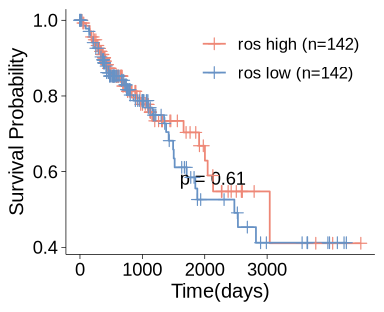

In [4]:


survive$ros = as.vector(ros_mean_expr[,rownames(survive)])
survive_plot2 = function(){
    gene = 'ros'
    sit1 = (survive_temp[,gene] >= median(survive_temp[,gene]))
    sit2 = (survive_temp[,gene] <= median(survive_temp[,gene]))
    survive_temp$signature[sit1] = paste0(gene,' high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0(gene,' low (n=',sum(sit2),')')
    survive_temp = survive_temp[survive_temp$signature!='none',]
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #指定颜色
    colors = c("#EE8776", "#6792C5")
    names(colors) = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')'))
    #plot
    options(repr.plot.width = 3.2, repr.plot.height = 2.6)
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1600, y = 0.6, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.7,0.8),
                  title = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
                  legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
                  axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
                ) + 
        add_censor_mark() +
        labs(x = 'Time(days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')),
                            labels = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')))
}

survive_temp = survive
survive_plot2()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


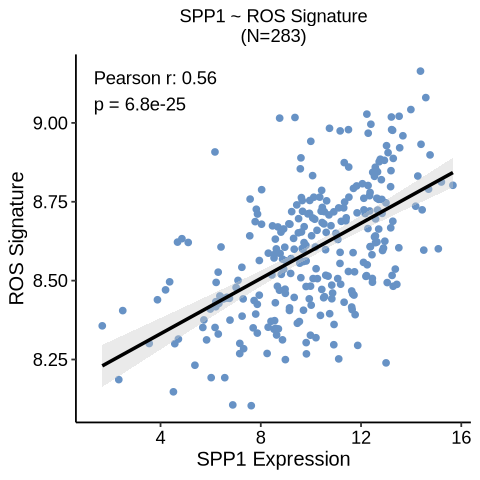

In [5]:
# 计算SPP1的表达水平和ROS signature的相关性，绘制点图

# 提取SPP1和ROS的表达数据，并确保它们是数值型
spp1_expr = as.numeric(as.vector(expr["SPP1", ]))
ros_expr = as.numeric(as.vector(ros_mean_expr))

# 计算相关性和p值
cor_test = cor.test(spp1_expr, ros_expr, method = "pearson")
correlation = cor_test$estimate
p_value = cor_test$p.value
correlation_label = paste0("Pearson r: ", round(correlation, 2), "\np = ", format(p_value, scientific = TRUE, digits = 2))

# 绘制点图
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data = data.frame(SPP1 = spp1_expr, ROS = ros_expr), aes(x = SPP1, y = ROS)) +
  geom_point(color = "#6792C5") +
  geom_smooth(method = "lm", color = "#000000", se = TRUE, fill = "grey80") +
  annotate("text", x = min(spp1_expr) * 0.8, y = max(ros_expr), label = correlation_label, hjust = 0, vjust = 1) +
  theme_classic() +
  labs(x = "SPP1 Expression", y = "ROS Signature", title = "SPP1 ~ ROS Signature\n(N=283)") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 11, family = "Helvetica", colour = "black"),
    axis.title.x = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.title.y = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.text.x = element_text(size = 11, family = "Helvetica", colour = "black"),
    axis.text.y = element_text(size = 11, family = "Helvetica", colour = "black")
  )
  ggsave(filename = "SPP1_ROS_signature_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 4, height = 4, dpi = 300)


# Infiltration Analysis

In [5]:
infiltration <- read.csv('/home/wpy/stereoseq/20240802-Tumor/infiltration_estimation_for_tcga.csv')
infiltration = as.data.frame(infiltration)
rownames(infiltration) = infiltration[,1]
infiltration = infiltration[,-1]
row.names(infiltration) = gsub('-01','',row.names(infiltration))
infiltration <- t(infiltration[row.names(infiltration) %in% colnames(expr),])
infiltration[grep("CD8", rownames(infiltration)), ]

,TCGA-3L-AA1B,TCGA-4N-A93T,TCGA-4T-AA8H,TCGA-5M-AAT4,TCGA-5M-AAT6,TCGA-5M-AATE,TCGA-A6-2675,TCGA-A6-2682,TCGA-A6-2684,TCGA-A6-2685,⋯,TCGA-QG-A5YV,TCGA-QG-A5YW,TCGA-QG-A5YX,TCGA-QG-A5Z1,TCGA-QG-A5Z2,TCGA-QL-A97D,TCGA-RU-A8FL,TCGA-SS-A7HO,TCGA-T9-A92H,TCGA-WS-AB45
T.cell.CD8._TIMER,0.1176490645,2.041340e-02,8.373230e-02,4.465672e-02,0.236280254,0.115155998,2.154577e-01,1.479435e-01,1.623259e-01,2.270984e-01,⋯,0.123040101,8.218391e-02,0.119242125,1.870194e-01,0.21163523,1.854324e-01,8.060607e-02,1.166553e-01,1.483363e-01,2.749756e-01
T.cell.CD8._CIBERSORT,0.0669402939,1.232580e-01,7.198516e-02,1.565570e-01,0.138500352,0.083966802,4.579441e-02,2.145458e-02,5.984819e-02,4.103026e-02,⋯,0.084959439,3.630730e-02,0.051471285,1.479087e-02,0.18632043,1.769894e-01,1.128356e-01,1.244521e-01,1.883150e-01,1.526668e-02
T.cell.CD8._CIBERSORT.ABS,0.0330635702,2.039702e-02,8.987884e-03,2.527828e-02,0.103557233,0.015625814,2.916011e-02,9.428256e-03,3.720821e-02,2.812103e-02,⋯,0.021290010,1.488177e-02,0.009617868,3.336466e-03,0.12187784,6.899512e-02,6.351473e-03,2.013674e-02,3.206349e-02,1.684408e-02
T.cell.CD8._QUANTISEQ,0.0006680361,1.572919e-04,0.000000e+00,3.962214e-04,0.020899633,0.003219986,0.000000e+00,0.000000e+00,1.054871e-03,0.000000e+00,⋯,0.000000000,0.000000e+00,0.000000000,0.000000e+00,0.02005549,1.275034e-02,0.000000e+00,2.337307e-03,0.000000e+00,6.838655e-04
T.cell.CD8._MCPCOUNTER,4.5468787402,2.427848e+00,7.868650e-01,4.062996e+00,7.212424712,5.195086389,8.032592e-01,3.709429e+00,1.946302e+00,1.720297e+00,⋯,1.608438882,5.472604e-01,4.810184583,9.932952e-02,8.36652211,3.295144e+00,4.072002e-01,1.288263e+01,3.039944e-01,1.976629e+00
T.cell.CD8..naive_XCELL,0.0126134004,1.307441e-02,1.336189e-02,1.365836e-02,0.019024219,0.012996376,1.084198e-02,8.629128e-03,1.135955e-02,6.182361e-03,⋯,0.012627671,1.018914e-02,0.013774092,8.582478e-03,0.02002799,2.269096e-02,1.091805e-02,1.583384e-02,1.297936e-02,3.586942e-04
T.cell.CD8._XCELL,0.0086699776,1.827034e-02,1.025186e-02,2.085270e-19,0.059902233,0.014370893,5.837931e-04,2.259502e-18,4.636843e-03,0.000000e+00,⋯,0.001116983,4.425745e-03,0.004184370,2.182190e-20,0.05038844,5.740591e-02,9.731022e-03,2.930861e-02,1.159540e-02,2.976420e-18
T.cell.CD8..central.memory_XCELL,0.0000000000,1.415466e-19,1.311566e-18,0.000000e+00,0.065595388,0.000000000,3.594805e-03,0.000000e+00,7.414041e-03,0.000000e+00,⋯,0.000000000,8.363396e-03,0.000000000,0.000000e+00,0.05145632,4.170939e-02,1.230985e-18,4.704299e-19,2.374112e-19,0.000000e+00
T.cell.CD8..effector.memory_XCELL,0.0000000000,3.337897e-18,1.940344e-18,7.675993e-18,0.007538958,0.000000000,1.898771e-19,0.000000e+00,7.385840e-18,3.508355e-18,⋯,0.000000000,2.886096e-18,0.000000000,0.000000e+00,0.00000000,2.851263e-22,0.000000e+00,1.582653e-18,0.000000e+00,1.119674e-18
T.cell.CD8._EPIC,0.0150702632,1.451178e-02,1.273838e-02,1.160467e-02,0.008539081,0.013594373,1.406989e-03,5.769615e-03,9.742020e-03,7.235945e-03,⋯,0.008781025,3.899348e-03,0.013169113,1.066043e-02,0.02064993,1.238347e-02,8.134358e-03,2.513503e-02,7.230153e-03,2.654542e-04


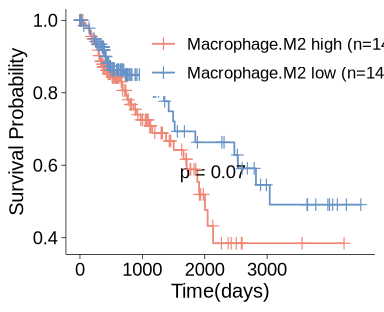

In [47]:
survive$Macrophage.M2 = as.vector(infiltration['Macrophage.M2_CIBERSORT',rownames(survive)])
survive_plot2 = function(){
    gene = 'Macrophage.M2'
    sit1 = (survive_temp[,gene] >= median(survive_temp[,gene]))
    sit2 = (survive_temp[,gene] <= median(survive_temp[,gene]))
    survive_temp$signature[sit1] = paste0(gene,' high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0(gene,' low (n=',sum(sit2),')')
    survive_temp = survive_temp[survive_temp$signature!='none',]
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #指定颜色
    colors = c("#EE8776", "#6792C5")
    names(colors) = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')'))
    #plot
    options(repr.plot.width = 3.2, repr.plot.height = 2.6)
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1600, y = 0.6, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.7,0.8),
                  title = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
                  legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
                  axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
                ) + 
        add_censor_mark() +
        labs(x = 'Time(days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')),
                            labels = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')))
}

survive_temp = survive
survive_plot2()

In [ ]:
survdiff

[1] "Both high (n=89)"       "Both low (n=88)"        "SPP1 high (n=53)"      
[4] "Macrophage high (n=53)"


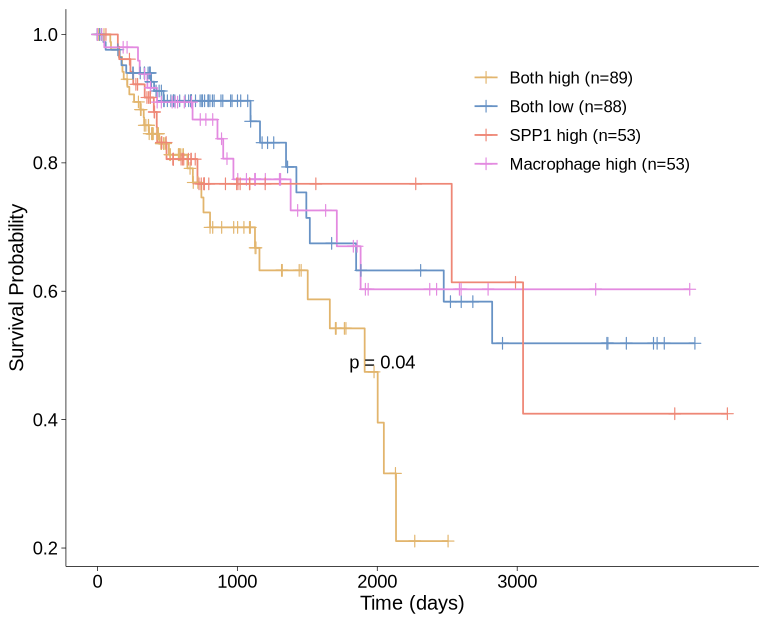

In [9]:
survive$SPP1 = as.vector(t(expr['SPP1',rownames(survive)]))
survive$Macrophage = as.vector(infiltration['Macrophage.M2_CIBERSORT',rownames(survive)])

sruvive_plot1 = function(gene1){
    #指定基因
    gene2 = 'Macrophage'
    #初始化signature
    survive_temp = survive
    survive_temp$signature = 'none'
    #为每个sample分配一个标签
    quantiles1 = quantile(survive_temp[,gene1],seq(0,1,0.1))
    quantiles2 = quantile(survive_temp[,gene2],seq(0,1,0.1))
    sit1 = (survive_temp[,gene1] >= median(survive_temp[,gene1])) & (survive_temp[,gene2] >= median(survive_temp[,gene2]))
    sit2 = (survive_temp[,gene1] < median(survive_temp[,gene1])) & (survive_temp[,gene2] < median(survive_temp[,gene2]))
    sit3 = (survive_temp[,gene1] >= median(survive_temp[,gene1])) & (survive_temp[,gene2] < median(survive_temp[,gene2]))
    sit4 = (survive_temp[,gene1] < median(survive_temp[,gene1])) & (survive_temp[,gene2] >= median(survive_temp[,gene2]))
    
    survive_temp$signature[sit1] = paste0('Both high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0('Both low (n=',sum(sit2),')')
    survive_temp$signature[sit3] = paste0(gene1,' high (n=',sum(sit3),')')
    survive_temp$signature[sit4] = paste0(gene2,' high (n=',sum(sit4),')')
    survive_temp = survive_temp[!survive_temp$signature == 'none',]
    
    #指定颜色
    colors = c('#E2B56D','#6792C5','#EE8776','#E38AE0')
    names(colors) = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')'))
    print(names(colors))
    #计算p值
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #plot
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1800, y = 0.5, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.75,0.8),
              title = element_text(size = 11,family="Helvetica",colour = "black"),
              axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
              axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
              axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
              axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
              legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
              axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
              axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
              axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
              axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
            ) + 
        add_censor_mark() +
        labs(x = 'Time (days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')')),
                            labels = c(paste0('Both high (n=',sum(sit1),')'), paste0('Both low (n=',sum(sit2),')'), paste0(gene1,' high (n=',sum(sit3),')'), paste0(gene2,' high (n=',sum(sit4),')')))
}

options(repr.plot.width = 6.4, repr.plot.height = 5.2)
sruvive_plot1('SPP1')

ggsave(filename = "SPP1_Macrophage_survival_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 6.4, height = 5.2, dpi = 300)

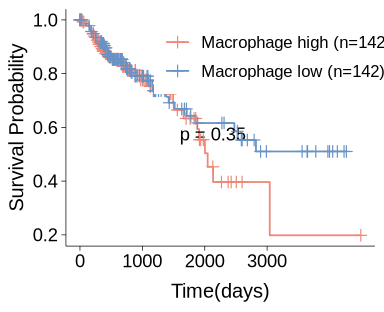

In [32]:
survive_plot2 = function(){
    gene = 'Macrophage'
    sit1 = (survive_temp[,gene] >= median(survive_temp[,gene]))
    sit2 = (survive_temp[,gene] <= median(survive_temp[,gene]))
    survive_temp$signature[sit1] = paste0(gene,' high (n=',sum(sit1),')')
    survive_temp$signature[sit2] = paste0(gene,' low (n=',sum(sit2),')')
    survive_temp = survive_temp[survive_temp$signature!='none',]
    res = survdiff(Surv(OS.time,OS) ~ signature, data = survive_temp)
    p.value <- round(1 - pchisq(res$chisq, length(res$n) -1),digits = 2)
    #指定颜色
    colors = c("#EE8776", "#6792C5")
    names(colors) = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')'))
    #plot
    options(repr.plot.width = 3.2, repr.plot.height = 2.6)
    survfit2(Surv(OS.time,OS) ~ signature, data = survive_temp) %>% 
      ggsurvfit() + 
        annotate(geom = "text", x = 1600, y = 0.6, label = paste0('p = ',p.value) ,hjust = 0, vjust = 1) + 
        scale_x_continuous(breaks = seq(0,3000,1000)) + 
        theme_classic() + 
        theme(legend.position = c(0.7,0.8),
                  title = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.title.x = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.title.y = element_text(size = 12,family="Helvetica",colour = "black"),
                  axis.text.x = element_text(size = 11,family="Helvetica",colour = "black"),
                  axis.text.y = element_text(size = 11,family="Helvetica",colour = "black"),
                  legend.text = element_text(size = 10,family="Helvetica",colour = "black"),
                  axis.line.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.line.y=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.x=element_line(linetype=1,color="black",linewidth=0.2),
                  axis.ticks.y=element_line(linetype=1,color="black",linewidth=0.2)
                ) + 
        add_censor_mark() +
        labs(x = 'Time(days)') + 
        scale_color_manual(values = colors,
                            breaks = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')),
                            labels = c(paste0(gene,' high (n=',sum(sit1),')'), paste0(gene,' low (n=',sum(sit2),')')))
}

survive_temp = survive
survive_plot2()

[1] 283


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


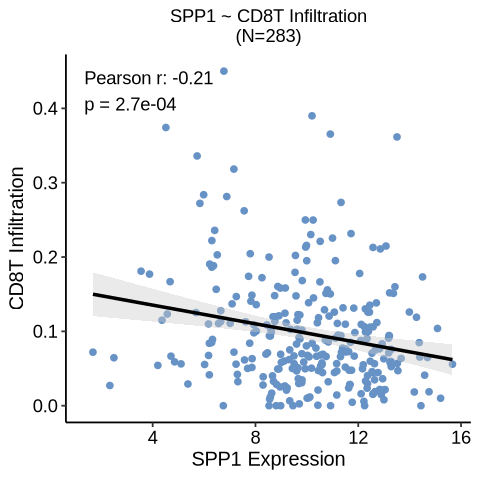

In [10]:
# 计算SPP1的表达水平和ROS signature的相关性，绘制点图

# 提取SPP1和ROS的表达数据，并确保它们是数值型
spp1_expr = as.numeric(as.vector(expr["SPP1", ]))
macrophage_expr = as.numeric(as.vector(infiltration['T.cell.CD8._CIBERSORT',rownames(survive)]))
print(length(macrophage_expr))

# 计算相关性
cor_test = cor.test(spp1_expr, macrophage_expr, method = "pearson")
correlation = cor_test$estimate
p_value = cor_test$p.value
correlation_label = paste0("Pearson r: ", round(correlation, 2), "\np = ", format(p_value, scientific = TRUE, digits = 2))

# 绘制点图
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data = data.frame(SPP1 = spp1_expr, Macrophage = macrophage_expr), aes(x = SPP1, y = Macrophage)) +
  geom_point(color = "#6792C5") +
  geom_smooth(method = "lm", color = "#000000", se = TRUE, fill = "grey80") +
  annotate("text", x = min(spp1_expr) * 0.8, y = max(macrophage_expr), label = correlation_label, hjust = 0, vjust = 1) +
  theme_classic() +
  labs(x = "SPP1 Expression", y = "CD8T Infiltration", title = "SPP1 ~ CD8T Infiltration\n(N=283)") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 11, family = "Helvetica", colour = "black"),
    axis.title.x = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.title.y = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.text.x = element_text(size = 11, family = "Helvetica", colour = "black"),
    axis.text.y = element_text(size = 11, family = "Helvetica", colour = "black")
  )
  ggsave(filename = "SPP1_CD8T_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 4, height = 4, dpi = 300)


[1] 283


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


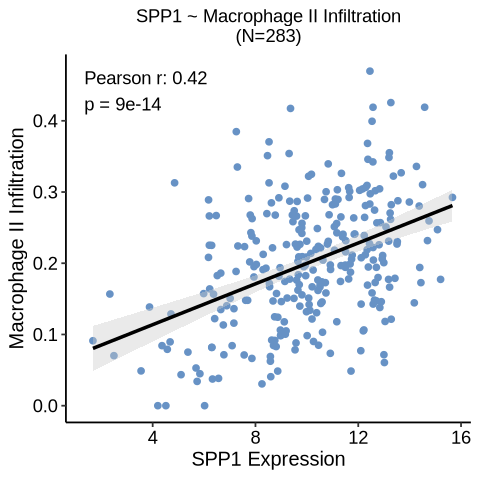

In [11]:
# 计算SPP1的表达水平和ROS signature的相关性，绘制点图

# 提取SPP1和ROS的表达数据，并确保它们是数值型
spp1_expr = as.numeric(as.vector(expr["SPP1", ]))
macrophage_expr = as.numeric(as.vector(infiltration['Macrophage.M2_CIBERSORT',rownames(survive)]))
print(length(macrophage_expr))

# 计算相关性
cor_test = cor.test(spp1_expr, macrophage_expr, method = "pearson")
correlation = cor_test$estimate
p_value = cor_test$p.value
correlation_label = paste0("Pearson r: ", round(correlation, 2), "\np = ", format(p_value, scientific = TRUE, digits = 2))

# 绘制点图
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data = data.frame(SPP1 = spp1_expr, Macrophage = macrophage_expr), aes(x = SPP1, y = Macrophage)) +
  geom_point(color = "#6792C5") +
  geom_smooth(method = "lm", color = "#000000", se = TRUE, fill = "grey80") +
  annotate("text", x = min(spp1_expr) * 0.8, y = max(macrophage_expr), label = correlation_label, hjust = 0, vjust = 1) +
  theme_classic() +
  labs(x = "SPP1 Expression", y = "Macrophage II Infiltration", title = "SPP1 ~ Macrophage II Infiltration\n(N=283)") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 11, family = "Helvetica", colour = "black"),
    axis.title.x = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.title.y = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.text.x = element_text(size = 11, family = "Helvetica", colour = "black"),
    axis.text.y = element_text(size = 11, family = "Helvetica", colour = "black")
  )
  ggsave(filename = "SPP1_Macrophage_II_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 4, height = 4, dpi = 300)

In [14]:
print(infiltration)

                                               TCGA-3L-AA1B TCGA-4N-A93T
B.cell_TIMER                                   1.274423e-01 3.550285e-02
T.cell.CD4._TIMER                              1.981696e-01 1.489344e-01
T.cell.CD8._TIMER                              1.176491e-01 2.041340e-02
Neutrophil_TIMER                               8.218652e-02 5.602494e-02
Macrophage_TIMER                               4.270002e-02 0.000000e+00
Myeloid.dendritic.cell_TIMER                   4.266671e-01 2.839699e-01
B.cell.naive_CIBERSORT                         5.029470e-02 1.539220e-02
B.cell.memory_CIBERSORT                        0.000000e+00 4.428217e-02
B.cell.plasma_CIBERSORT                        7.199127e-02 1.948297e-01
T.cell.CD8._CIBERSORT                          6.694029e-02 1.232580e-01
T.cell.CD4..naive_CIBERSORT                    0.000000e+00 0.000000e+00
T.cell.CD4..memory.resting_CIBERSORT           1.333804e-01 1.775626e-01
T.cell.CD4..memory.activated_CIBERSORT         0.00

[1] 283


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


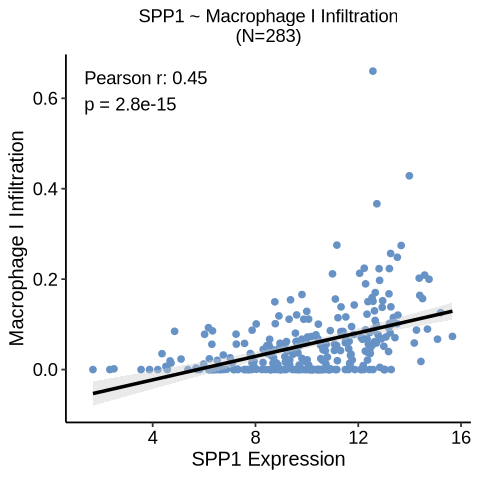

In [15]:
# 计算SPP1的表达水平和ROS signature的相关性，绘制点图

# 提取SPP1和ROS的表达数据，并确保它们是数值型
spp1_expr = as.numeric(as.vector(expr["SPP1", ]))
macrophage_expr = as.numeric(as.vector(infiltration['Macrophage_TIMER',rownames(survive)]))
print(length(macrophage_expr))

# 计算相关性
cor_test = cor.test(spp1_expr, macrophage_expr, method = "pearson")
correlation = cor_test$estimate
p_value = cor_test$p.value
correlation_label = paste0("Pearson r: ", round(correlation, 2), "\np = ", format(p_value, scientific = TRUE, digits = 2))

# 绘制点图
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data = data.frame(SPP1 = spp1_expr, Macrophage = macrophage_expr), aes(x = SPP1, y = Macrophage)) +
  geom_point(color = "#6792C5") +
  geom_smooth(method = "lm", color = "#000000", se = TRUE, fill = "grey80") +
  annotate("text", x = min(spp1_expr) * 0.8, y = max(macrophage_expr), label = correlation_label, hjust = 0, vjust = 1) +
  theme_classic() +
  labs(x = "SPP1 Expression", y = "Macrophage I Infiltration", title = "SPP1 ~ Macrophage I Infiltration\n(N=283)") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 11, family = "Helvetica", colour = "black"),
    axis.title.x = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.title.y = element_text(size = 12, family = "Helvetica", colour = "black"),
    axis.text.x = element_text(size = 11, family = "Helvetica", colour = "black"),
    axis.text.y = element_text(size = 11, family = "Helvetica", colour = "black")
  )
  ggsave(filename = "SPP1_Macrophage_I_plot.pdf", path = "/home/wpy/stereoseq/20240802-Tumor/plots", width = 4, height = 4, dpi = 300)
